## Train sea lion classifier with a convnet

In [1]:
INPUT_DIR = '../../input/kaggle-sea-lion/02/'
OUTPUT_DIR = '../../output/kaggle-sea-lion/05/'
#IMAGE_DIMS = (148,148,3)
IMAGE_DIMS = (84,84,3)
#IMAGE_DIMS = (32,32,3)

INPUT_DATASET_NAME = 'lion-patches-0px'
SAVE_WEIGHTS_FILE = OUTPUT_DIR + 'last-weights.h5'
LOAD_WEIGHTS_FILE = OUTPUT_DIR + 'weights/weights-47-0.72.h5'

RECREATE_OUTPUT_DIR = False
RUN_TRAINING = True

OUTPUT_WEIGHT = (1,1,1,1,1,1)
TRAIN_EPOCHS = 1
INPUT_RANGE = 0.2

BATCH_SIZE=64

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import sklearn
import os
import glob

import keras
from keras.preprocessing.image import ImageDataGenerator

from modules.logging import logger
import modules.utils as utils
from modules.utils import Timer
import modules.logging
import modules.cnn as cnn
import modules.lions as lions

Using TensorFlow backend.


## Prepare

### Prepare output dir

In [3]:
utils.mkdirs(OUTPUT_DIR, dirs=['tf-logs','weights'], recreate=RECREATE_OUTPUT_DIR)
modules.logging.setup_file_logger(OUTPUT_DIR + 'out.log')
TF_LOGS_DIR = OUTPUT_DIR + 'tf-logs/'
WEIGHTS_DIR = OUTPUT_DIR + 'weights/'
input_dataset_path = INPUT_DIR + utils.dataset_name(INPUT_DATASET_NAME, IMAGE_DIMS)

logger.info('Output dirs created')

2017-04-23 13:51:04,315 INFO Output dirs created


### Prepare CNN model

In [4]:
logger.info('Load CNN model')
#model = lions.convnet_alexnet2_lion_keras(IMAGE_DIMS)
model = lions.convnet_simple_lion_keras(IMAGE_DIMS)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

if(LOAD_WEIGHTS_FILE!=None and os.path.isfile(LOAD_WEIGHTS_FILE)):
    logger.info('Loading previous weights...')
    model.load_weights(LOAD_WEIGHTS_FILE)

logger.info('Model prepared')

2017-04-23 13:51:04,325 INFO Load CNN model
2017-04-23 13:51:04,495 INFO Loading previous weights...
2017-04-23 13:51:05,847 INFO Model prepared


### Prepare train, validate and test data flows

In [5]:
logger.info('Using dataset ' + input_dataset_path + ' as input')
h5file = h5py.File(input_dataset_path, 'r')

image_randomize_generator = ImageDataGenerator(
        featurewise_center=True,
        samplewise_center=False,
        featurewise_std_normalization=True,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=359,
        width_shift_range=0,
        height_shift_range=0,
        horizontal_flip=True,
        vertical_flip=True)

logger.info('preparing train data')
train_batch_generator = utils.BatchGeneratorXYH5(h5file, start_ratio=0, end_ratio=INPUT_RANGE)
train_balance_generator = utils.ClassBalancerGeneratorXY(train_batch_generator,
                                                         image_augmentation=image_randomize_generator,
                                                         output_weight=OUTPUT_WEIGHT,
                                                         max_augmentation_ratio=5,
                                                         max_undersampling_ratio=1,
                                                         enforce_max_ratios=False,
                                                         tmp_dir=OUTPUT_DIR,
                                                         use_tmp=False,
                                                         start_ratio=0, end_ratio=0.7)
train_generator = utils.image_augmentation_xy(train_balance_generator.flow(), image_randomize_generator)
logger.info('train size=' + str(train_balance_generator.size) + ' batches=' + str(train_balance_generator.nr_batches))


logger.info('preparing valid data')
valid_batch_generator = utils.BatchGeneratorXYH5(h5file, start_ratio=0, end_ratio=INPUT_RANGE)
valid_balance_generator = utils.ClassBalancerGeneratorXY(valid_batch_generator,
                                                         image_augmentation=image_randomize_generator,
                                                         output_weight=OUTPUT_WEIGHT,
                                                         max_augmentation_ratio=5,
                                                         max_undersampling_ratio=1,
                                                         enforce_max_ratios=False,
                                                         tmp_dir=OUTPUT_DIR,
                                                         use_tmp=True,
                                                         start_ratio=0.75, end_ratio=0.9)
logger.info('valid size=' + str(valid_balance_generator.size) + ' batches=' + str(valid_balance_generator.nr_batches))



logger.info('preparing test data')
test_batch_generator = utils.BatchGeneratorXYH5(h5file, start_ratio=0, end_ratio=INPUT_RANGE)
test_balance_generator = utils.ClassBalancerGeneratorXY(test_batch_generator,
                                                         image_augmentation=image_randomize_generator,
                                                         output_weight=OUTPUT_WEIGHT,
                                                         max_augmentation_ratio=5,
                                                         max_undersampling_ratio=1,
                                                         enforce_max_ratios=False,
                                                         tmp_dir=OUTPUT_DIR,
                                                         use_tmp=True,
                                                         start_ratio=0.9, end_ratio=1)
logger.info('test size=' + str(test_balance_generator.size) + ' batches=' + str(test_balance_generator.nr_batches))

#FIXME when using 1 on end ratio size and nr_batches gets negative (h5 batch generator, not balancer...)

2017-04-23 13:51:05,878 INFO Using dataset ../../input/kaggle-sea-lion/02/lion-patches-0px-84-84.h5 as input
2017-04-23 13:51:05,880 INFO preparing train data
2017-04-23 13:51:05,882 INFO loading input data for class distribution analysis...
2017-04-23 13:51:05,884 INFO loading Y from raw dataset
2017-04-23 13:51:05,885 INFO > [started] generator dump...


27072/27013

2017-04-23 13:51:16,100 INFO > [done]    generator dump (10214.708 ms)
2017-04-23 13:51:16,101 INFO saving Y to temp file ../../output/kaggle-sea-lion/05/class-balancer-5-1-(1, 1, 1, 1, 1, 1)-False-0-0.7.npy
2017-04-23 13:51:16,121 INFO raw sample class distribution
2017-04-23 13:51:16,122 INFO 0: 992
2017-04-23 13:51:16,124 INFO 1: 864
2017-04-23 13:51:16,125 INFO 2: 6739
2017-04-23 13:51:16,126 INFO 3: 3436
2017-04-23 13:51:16,127 INFO 4: 2892
2017-04-23 13:51:16,128 INFO 5: 12090
2017-04-23 13:51:16,130 INFO overall output samples per class: 5184
2017-04-23 13:51:16,131 INFO augmentation/undersampling ratio per class
2017-04-23 13:51:16,132 INFO SETUP FLOW 0 0.7
2017-04-23 13:51:16,134 INFO output distribution
2017-04-23 13:51:16,135 INFO 0: 5.22580645161 (3628.8)
2017-04-23 13:51:16,136 INFO 1: 6.0 (3628.8)
2017-04-23 13:51:16,137 INFO 2: 0.769253598457 (3628.8)
2017-04-23 13:51:16,138 INFO 3: 1.50873108265 (3628.8)
2017-04-23 13:51:16,140 INFO 4: 1.79253112033 (3628.8)
2017-04-23 

2017-04-23 13:51:16,423 INFO BALANCE GENERATOR DATA
2017-04-23 13:51:16,425 INFO > [started] generator dump...
2017-04-23 13:51:16,427 INFO starting new flow...
/usr/local/lib/python3.4/dist-packages/Keras-2.0.2-py3.4.egg/keras/preprocessing/image.py:500: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.4/dist-packages/Keras-2.0.2-py3.4.egg/keras/preprocessing/image.py:508: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


21824/21772

2017-04-23 13:52:06,199 INFO > [done]    generator dump (49773.151 ms)
2017-04-23 13:52:06,200 INFO y (21772, 6)
2017-04-23 13:52:06,215 INFO [4015 3672 4529 2816 2584 4156]
2017-04-23 13:52:06,217 INFO starting new flow...
2017-04-23 13:52:06,280 INFO showing 64 images
2017-04-23 13:52:06,282 INFO > [started] generating image patches. rows=7; cols=10...
/notebooks/datascience-snippets/kaggle-sea-lion/modules/utils.py:613: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if(image_labels!=None):


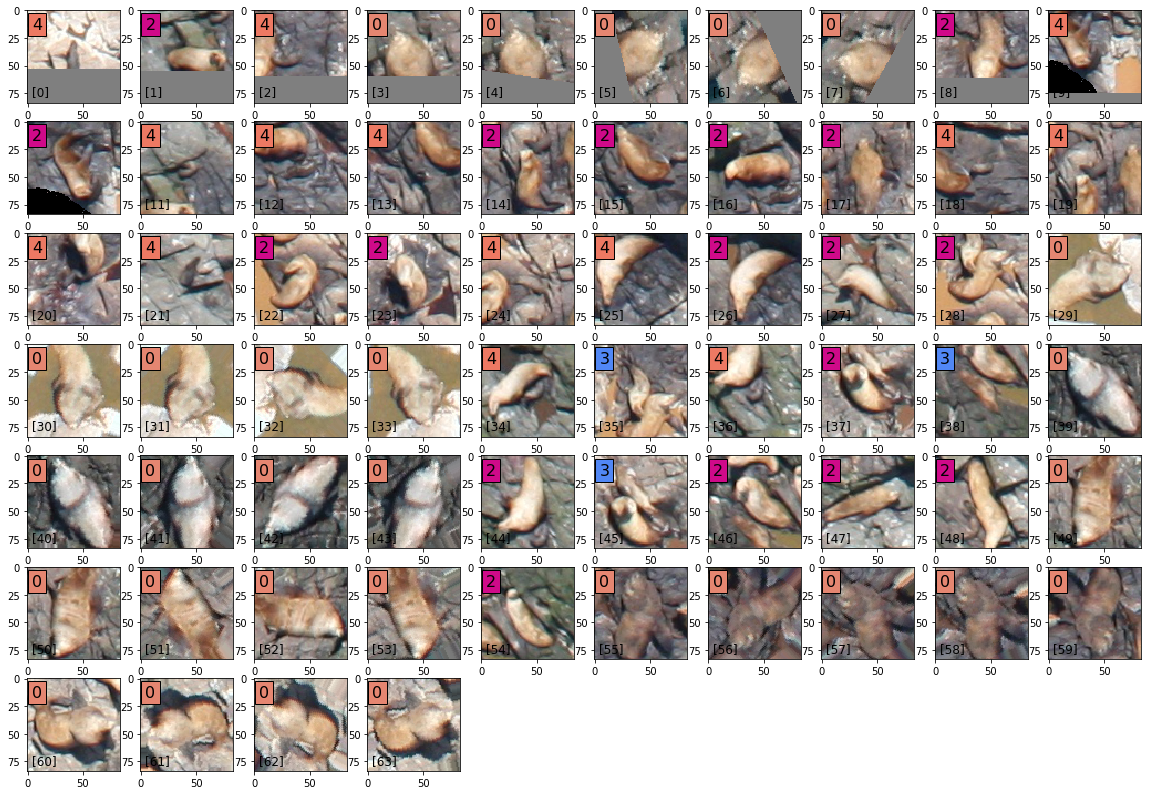

2017-04-23 13:52:14,377 INFO > [done]    generating image patches. rows=7; cols=10 (8095.099 ms)


In [ ]:
#logger.info('INPUT DATASET DATA')
#dataset_path = INPUT_DIR + utils.dataset_name(INPUT_DATASET_NAME, IMAGE_DIMS)
#with h5py.File(input_dataset_path, 'r') as h5file:
#    logger.info('generator')
#    input_generator = utils.BatchGeneratorXYH5(h5file, start_ratio=0.001, end_ratio=0.0012, batch_size=64)
#    X, Y = utils.dump_xy_to_array(input_generator.flow(), input_generator.size, x=True, y=True)
#    utils.show_images(X, image_labels=utils.onehot_to_label(Y), group_by_label=False, cols=10, is_bgr=True, size=2)
#
#    logger.info('x ' + str(np.shape(X)))
#    logger.info('y ' + str(np.shape(Y)))
#    logger.info(str(utils.class_distribution(Y)))

logger.info('BALANCE GENERATOR DATA')
dataset_path = INPUT_DIR + utils.dataset_name(INPUT_DATASET_NAME, IMAGE_DIMS)
X_train, Y_train = utils.dump_xy_to_array(train_generator, train_balance_generator.size, x=False, y=True)
#logger.info('x ' + str(np.shape(X_train)))
logger.info('y ' + str(np.shape(Y_train)))
logger.info(str(utils.class_distribution(Y_train)))

for xs,ys in train_balance_generator.flow():
    utils.show_images(xs, image_labels=utils.onehot_to_label(ys), cols=10, is_bgr=True, size=2)
    break

## Train model

In [ ]:
if(RUN_TRAINING):
    logger.info('Starting CNN training...')
    history = model.fit_generator(train_generator,
                  steps_per_epoch = train_balance_generator.nr_batches,
                  nb_epoch = TRAIN_EPOCHS,
                  callbacks = cnn.get_callbacks_keras(model, WEIGHTS_DIR, TF_LOGS_DIR),
                  validation_data = valid_balance_generator.flow(), 
                  validation_steps = valid_balance_generator.nr_batches,
                  verbose = 1)

    if(SAVE_WEIGHTS_FILE!=None):
        logger.info('Saving last weights...')
        model.save_weights(SAVE_WEIGHTS_FILE)

2017-04-23 13:52:14,402 INFO Starting CNN training...


INFO:tensorflow:Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.


2017-04-23 13:52:14,406 INFO Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.


INFO:tensorflow:Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.


2017-04-23 13:52:14,413 INFO Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.


INFO:tensorflow:Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.


2017-04-23 13:52:14,418 INFO Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.


INFO:tensorflow:Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.


2017-04-23 13:52:14,427 INFO Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.


INFO:tensorflow:Summary name conv2d_2/kernel:0 is illegal; using conv2d_2/kernel_0 instead.


2017-04-23 13:52:14,433 INFO Summary name conv2d_2/kernel:0 is illegal; using conv2d_2/kernel_0 instead.


INFO:tensorflow:Summary name conv2d_2/kernel:0 is illegal; using conv2d_2/kernel_0 instead.


2017-04-23 13:52:14,439 INFO Summary name conv2d_2/kernel:0 is illegal; using conv2d_2/kernel_0 instead.


INFO:tensorflow:Summary name conv2d_2/bias:0 is illegal; using conv2d_2/bias_0 instead.


2017-04-23 13:52:14,443 INFO Summary name conv2d_2/bias:0 is illegal; using conv2d_2/bias_0 instead.


INFO:tensorflow:Summary name conv2d_2/bias:0 is illegal; using conv2d_2/bias_0 instead.


2017-04-23 13:52:14,449 INFO Summary name conv2d_2/bias:0 is illegal; using conv2d_2/bias_0 instead.


INFO:tensorflow:Summary name conv2d_3/kernel:0 is illegal; using conv2d_3/kernel_0 instead.


2017-04-23 13:52:14,454 INFO Summary name conv2d_3/kernel:0 is illegal; using conv2d_3/kernel_0 instead.


INFO:tensorflow:Summary name conv2d_3/kernel:0 is illegal; using conv2d_3/kernel_0 instead.


2017-04-23 13:52:14,461 INFO Summary name conv2d_3/kernel:0 is illegal; using conv2d_3/kernel_0 instead.


INFO:tensorflow:Summary name conv2d_3/bias:0 is illegal; using conv2d_3/bias_0 instead.


2017-04-23 13:52:14,464 INFO Summary name conv2d_3/bias:0 is illegal; using conv2d_3/bias_0 instead.


INFO:tensorflow:Summary name conv2d_3/bias:0 is illegal; using conv2d_3/bias_0 instead.


2017-04-23 13:52:14,471 INFO Summary name conv2d_3/bias:0 is illegal; using conv2d_3/bias_0 instead.


INFO:tensorflow:Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.


2017-04-23 13:52:14,477 INFO Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.


INFO:tensorflow:Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.


2017-04-23 13:52:14,487 INFO Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.


INFO:tensorflow:Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.


2017-04-23 13:52:14,490 INFO Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.


INFO:tensorflow:Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.


2017-04-23 13:52:14,497 INFO Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.


INFO:tensorflow:Summary name dense_2/kernel:0 is illegal; using dense_2/kernel_0 instead.


2017-04-23 13:52:14,502 INFO Summary name dense_2/kernel:0 is illegal; using dense_2/kernel_0 instead.


INFO:tensorflow:Summary name dense_2/kernel:0 is illegal; using dense_2/kernel_0 instead.


2017-04-23 13:52:14,508 INFO Summary name dense_2/kernel:0 is illegal; using dense_2/kernel_0 instead.


INFO:tensorflow:Summary name dense_2/bias:0 is illegal; using dense_2/bias_0 instead.


2017-04-23 13:52:14,511 INFO Summary name dense_2/bias:0 is illegal; using dense_2/bias_0 instead.


INFO:tensorflow:Summary name dense_2/bias:0 is illegal; using dense_2/bias_0 instead.


2017-04-23 13:52:14,518 INFO Summary name dense_2/bias:0 is illegal; using dense_2/bias_0 instead.


INFO:tensorflow:Summary name dense_3/kernel:0 is illegal; using dense_3/kernel_0 instead.


2017-04-23 13:52:14,523 INFO Summary name dense_3/kernel:0 is illegal; using dense_3/kernel_0 instead.


INFO:tensorflow:Summary name dense_3/kernel:0 is illegal; using dense_3/kernel_0 instead.


2017-04-23 13:52:14,533 INFO Summary name dense_3/kernel:0 is illegal; using dense_3/kernel_0 instead.


INFO:tensorflow:Summary name dense_3/bias:0 is illegal; using dense_3/bias_0 instead.


2017-04-23 13:52:14,537 INFO Summary name dense_3/bias:0 is illegal; using dense_3/bias_0 instead.


INFO:tensorflow:Summary name dense_3/bias:0 is illegal; using dense_3/bias_0 instead.


2017-04-23 13:52:14,544 INFO Summary name dense_3/bias:0 is illegal; using dense_3/bias_0 instead.
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., callbacks=[<keras.ca..., steps_per_epoch=341, verbose=1, validation_data=<generator..., epochs=1, validation_steps=73)`


Epoch 1/1
Epoch 1/1


/usr/local/lib/python3.4/dist-packages/Keras-2.0.2-py3.4.egg/keras/preprocessing/image.py:500: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.4/dist-packages/Keras-2.0.2-py3.4.egg/keras/preprocessing/image.py:508: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 84/341 [======>.......................] - ETA: 619s - loss: 0.8558 - acc: 0.6814 

### Epoch accuracy/loss

In [ ]:
if(RUN_TRAINING):
    logger.info('Training info')
    cnn.show_training_info_keras(history)

### Confusion matrix

In [ ]:
cnn.evaluate_dataset_keras(test_balance_generator.flow(), 
                       test_balance_generator.nr_batches, 
                       test_balance_generator.size, 
                       model, 
                       class_labels=lions.CLASS_LABELS)

In [ ]:
a = test_balance_generator.flow()
cnn.show_predictions(a, 50, model)